In [1]:
import torch
import os
import random
from torch.utils.data import random_split

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from dataloader import RouteSegmentationDataset, TestDataset, SegmentationTransform

import albumentations as A

from skimage.transform import resize

from utils import plot_loss, DiceLoss

import matplotlib.image as mpimg
import torchvision.transforms as T

In [2]:
# Define hyperparameters
BATCH_SIZE = 8
EPOCHS = 50
LEARNING_RATE = 1e-4
N_CLASSES = 1
N_CHANNELS = 3
BOTTLENECK = 256

image_dir = "training/images"
mask_dir = "training/groundtruth"
image_dir_test = "test_set_images"

BEST_CHECKPOINTS_PATH = "checkpoints1/best_checkpoints.pt"

In [3]:
# Define augmentation pipeline
augmentations = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomResizedCrop(size=(256,256), scale=(0.25,0.5), ratio=(0.75, 1.3333333333333333), interpolation=1, mask_interpolation=0, p=0.5, always_apply=None),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5)
])

# Augment and save images
image_filenames = os.listdir(image_dir)
mask_filenames = os.listdir(mask_dir)

for i, (image_file, mask_file) in enumerate(zip(image_filenames, mask_filenames)):
    # Load image and mask
    image = np.array(Image.open(os.path.join(image_dir, image_file)))
    mask = np.array(Image.open(os.path.join(mask_dir, mask_file)))

    # Apply augmentations
    for j in range(35):
        augmented = augmentations(image=image, mask=mask)
        augmented_image = augmented['image']
        augmented_mask = augmented['mask']
        
        # Save augmented data
        Image.fromarray(augmented_image).save(os.path.join(image_dir, f"aug_image_{100+i}_{j}.png"))
        Image.fromarray(augmented_mask).save(os.path.join(mask_dir, f"aug_mask_{100+i}_{j}.png"))

print("Augmented data saved!")

Augmented data saved!


In [4]:
# Create datasets with consistent transformations
transform_training = SegmentationTransform()
transform_test = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor()
])

dataset = RouteSegmentationDataset(image_dir, mask_dir, transform=transform_training)
test_dataset = TestDataset(image_dir_test, transform=transform_test)

# Create DataLoaders
train_size = int(0.85 * len(dataset))
validation_size = len(dataset) - train_size
train_dataset, validation_dataset = random_split(dataset, [train_size, validation_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Verify the split
print(f"Total dataset size: {len(dataset)}")
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(validation_dataset)}")
print(f"Testing dataset size : {len(test_dataset)}")

train_features, train_labels = next(iter(train_loader))
print(f"Batch shape: {train_features.size()}")


Total dataset size: 3600
Training dataset size: 3060
Validation dataset size: 540
Testing dataset size : 50
Batch shape: torch.Size([8, 3, 256, 256])


In [5]:
# import and initialize the model
from unet import UNet
from resnet_unet import ResNetUnet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
# model = UNet(BOTTLENECK, N_CHANNELS, N_CLASSES).to(device)
model = ResNetUnet(N_CHANNELS, N_CLASSES).to(device)

Using device: cuda


c:\Users\qchap\OneDrive\Donnees\EPFL\MA1\ML\projects\env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\qchap\OneDrive\Donnees\EPFL\MA1\ML\projects\env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training loss for epoch 0: 0.316685
Validation loss for epoch 0: 0.179735
Validation loss for epoch 1: 0.154461
Validation loss for epoch 2: 0.143884
Validation loss for epoch 3: 0.133058
Validation loss for epoch 4: 0.123393
Training loss for epoch 5: 0.119413
Validation loss for epoch 5: 0.118548
Validation loss for epoch 6: 0.113670
Validation loss for epoch 7: 0.103440
Validation loss for epoch 8: 0.101032
Validation loss for epoch 9: 0.099436
Training loss for epoch 10: 0.098941
Validation loss for epoch 10: 0.098214


KeyboardInterrupt: 

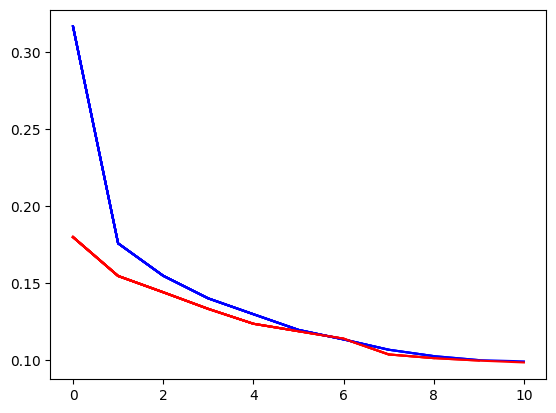

In [6]:
# loss_fn = torch.nn.BCELoss()
loss_fn = DiceLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)

# Training loop 
training_losses = []
validation_losses = []

iterations = []

for epoch in range(EPOCHS):
    model.train()
    avg_loss = 0
    for batch, (X, y) in enumerate(train_loader):
        optimizer.zero_grad()
        
        X, y = X.to(device), y.to(device)
        
        pred = model(X)
        loss = loss_fn(pred, y)
        
        loss.backward()
        optimizer.step()

        avg_loss += loss.item()
        
    scheduler.step()

    avg_loss /= len(train_loader)
    training_losses.append(avg_loss)
    if epoch % 5 == 0:
        print(f"Training loss for epoch {epoch}: {avg_loss:>7f}")

    avg_loss = 0
    model.eval()
    with torch.no_grad():
        for X, y in validation_loader:
            X, y = X.to(device), y.to(device)
        
            pred = model(X)

            loss = loss_fn(pred, y)
            avg_loss += loss.item()

        avg_loss /= len(validation_loader)
        validation_losses.append(avg_loss)
        
        print(f"Validation loss for epoch {epoch}: {avg_loss:>7f}")

        if len(validation_losses) == 0 or avg_loss <= min(validation_losses): # save the best epoch checkpoints
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()  
                }, "checkpoints2/model8.pt")

    plot_loss(training_losses, validation_losses)

In [7]:
# model = UNet(BOTTLENECK, N_CHANNELS, N_CLASSES).to(device)
model = ResNetUnet(N_CHANNELS, N_CLASSES).to(device)
checkpoint = torch.load("checkpoints2/model8.pt")
model.load_state_dict(checkpoint['model_state_dict'])

C:\Users\qchap\AppData\Local\Temp\ipykernel_15528\949614571.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("checkpoints2/model8.pt")


<All keys matched successfully>

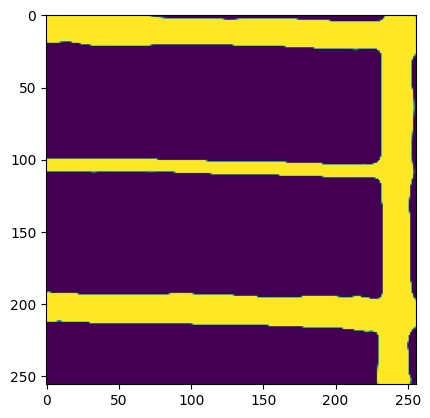

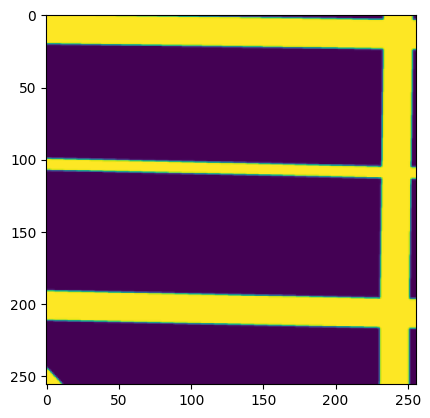

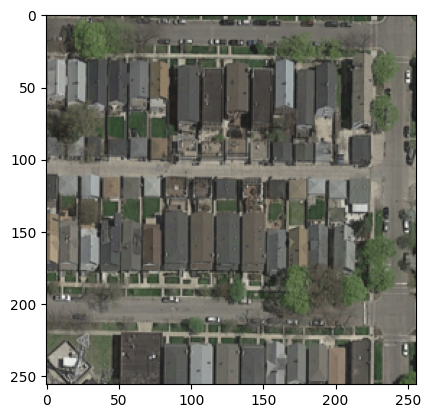

In [17]:
images, masks = next(iter(validation_loader))
image, mask = images[0], masks[0]
image = image.unsqueeze(0).to("cuda")
model.to("cuda")
pred = model(image)
plt.imshow(pred[0].transpose(0, 2).cpu().detach().numpy())
plt.show()
plt.imshow(mask.transpose(0, 2).cpu().detach().numpy())
plt.show()
plt.imshow(image[0].transpose(0, 2).cpu().detach().numpy())
plt.show()

In [18]:
# load test set images for later use
test_images = []
for i in range(50):
    mask_path = os.path.join(image_dir_test, sorted(os.listdir(image_dir_test), key=lambda x: int(x.split('_')[1].split('.')[0]))[i])
    test_images.append(np.array(Image.open(mask_path)))

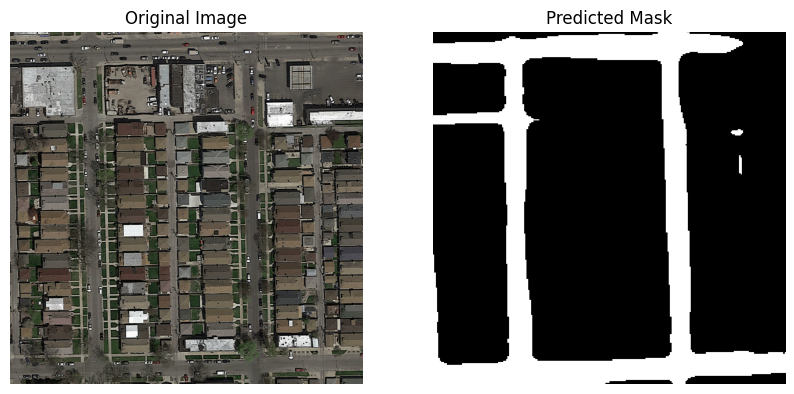

In [30]:
# Set model to evaluation mode
model.eval()

# Place to store predictions
all_predictions = []

with torch.no_grad():
    for image in test_dataset:
        image = image.unsqueeze(0).to(device)

        output = model(image)
        output = output.cpu().detach().numpy()

        threshold = 0.25
        predicted_labels = (output > threshold).astype(np.float32)

        all_predictions.append(predicted_labels)

all_predictions = np.concatenate(all_predictions, axis=0)
final_all_predictions = []

for i in range(50):
    final_all_predictions.append(resize(all_predictions[i][0], test_images[i].shape, order=0))

sample_idx = random.randint(0, 49)
image = test_images[sample_idx]
predicted_mask = final_all_predictions[sample_idx]

plt.figure(figsize=(10, 5))

# Plot original image
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

# Plot predicted mask
plt.subplot(1, 2, 2)
plt.imshow(predicted_mask, cmap='gray', vmin=0, vmax=1)
plt.title("Predicted Mask")
plt.axis("off")

plt.show()

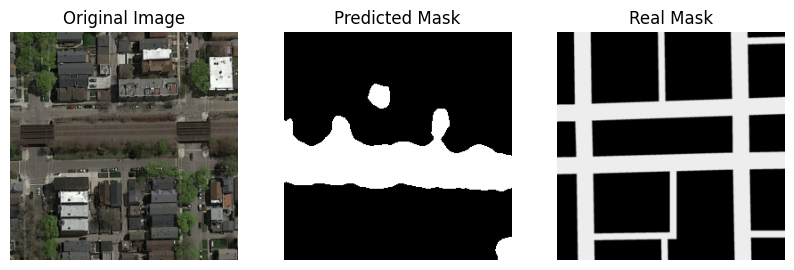

In [35]:
# Set model to evaluation mode
model.eval()

# Place to store predictions
all_predictions = []
images = []
masks = []

with torch.no_grad():  # No need to compute gradients for inference
    for image, mask in train_loader:  # Assuming you're passing just the images
        masks.append(mask)
        # Move images to the correct device (GPU or CPU)
        images.append(image.cpu().detach().numpy())  # Save CPU copy for visualization
        image = image.to(device)

        # Forward pass: Get the predicted output from the model
        output = model(image)
        output = output.cpu().detach().numpy()

        # Convert the probabilities to binary predictions (0 or 1)
        threshold = 0.4
        predicted_labels = (output > threshold).astype(np.float32)

        # Collect predictions
        all_predictions.append(predicted_labels)

# Convert predictions to a numpy array
all_predictions = np.concatenate(all_predictions, axis=0)

# Display one test sample and its prediction
sample_idx = 4
image = images[sample_idx][0]
predicted_mask = all_predictions[sample_idx]

plt.figure(figsize=(10, 5))

# Plot original image
plt.subplot(1, 3, 1)
image = np.transpose(images[sample_idx][0], (1, 2, 0))  # Transpose to (H, W, C)
plt.imshow(image, cmap='gray' if image.shape[-1] == 1 else None)
plt.title("Original Image")
plt.axis("off")

# Plot predicted mask
plt.subplot(1, 3, 2)
predicted_mask = all_predictions[sample_idx][0]
plt.imshow(predicted_mask, cmap='gray', vmin=0, vmax=1)
plt.title("Predicted Mask")
plt.axis("off")

# Plot predicted mask
plt.subplot(1, 3, 3)
plt.imshow(np.transpose(masks[sample_idx][0], (1, 2, 0)), cmap='gray', vmin=0, vmax=1)
plt.title("Real Mask")
plt.axis("off")

plt.show()

In [31]:
# create predictions on test set
os.makedirs("test_set_preds", exist_ok=True)

for i in range(len(all_predictions)):
    mask = final_all_predictions[i]
    mask_uint8 = (mask * 255).astype(np.uint8)
    Image.fromarray(mask_uint8).save(f"test_set_preds/pred_{i + 1}.png")

In [32]:
foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

# assign a label to a patch
def patch_to_label(patch):
    df = np.mean(patch)
    if df > foreground_threshold:
        return 1
    else:
        return 0


def mask_to_submission_strings(image_filename, img_number):
    """Reads a single image and outputs the strings that should go into the submission file"""
    im = mpimg.imread(image_filename)
    patch_size = 16
    for j in range(0, im.shape[1], patch_size):
        for i in range(0, im.shape[0], patch_size):
            patch = im[i:i + patch_size, j:j + patch_size]
            label = patch_to_label(patch)
            yield("{:03d}_{}_{},{}".format(img_number, j, i, label))


def masks_to_submission(submission_filename, *image_filenames):
    """Converts images into a submission file"""
    with open(submission_filename, 'w') as f:
        f.write('id,prediction\n')
        i = 1
        for fn in image_filenames[0:]:
            f.writelines('{}\n'.format(s) for s in mask_to_submission_strings(fn, i))
            i+=1


submission_filename = "final_submission.csv"
image_filenames = []
for i in range(1, 51):
    image_filename = f"test_set_preds/pred_{i}.png"
    image_filenames.append(image_filename)
masks_to_submission(submission_filename, *image_filenames)